## Analyze of Instagram profile

Adapted by Gunther Correia Bacellar from internet using the instagramAPI

Before to use, install the Python package: InstagramAPI (pip install InstagramAPI)

### Define the functions to login, get posts, likers, commenters and create dataframes

In [27]:
from InstagramAPI import InstagramAPI
import pandas as pd
from pandas.io.json import json_normalize
import time

def login_to_instagram(username, password):
    api = InstagramAPI(username, password)
    api.login()
    return api

def get_my_posts(api):
    '''Retrieve all posts from own profile'''
    my_posts = []
    has_more_posts = True
    max_id= ''

    while has_more_posts:
        api.getSelfUserFeed(maxid=max_id)
        if api.LastJson['more_available'] is not True:
            has_more_posts = False #stop condition

        max_id = api.LastJson.get('next_max_id','')
        my_posts.extend(api.LastJson['items']) #merge lists
        time.sleep(2) # slows down to avoid flooding

        if has_more_posts:
            print(str(len(my_posts)) + ' posts retrieved so far...')
    return my_posts

def get_posts_likers(api, my_posts):
    '''Retrieve all likers on all posts'''
    
    likers = []
    
    print('wait %.1f minutes' % (len(my_posts)*2/60.))
    for i in range(len(my_posts)):
        m_id = my_posts[i]['id']
        api.getMediaLikers(m_id)
        
        likers += [api.LastJson]
        
        # Include post_id in likers dict list
        likers[i]['post_id'] = m_id
        
        time.sleep(2)
    print('done')
    
    return likers

def get_posts_commenters(api, my_posts):
    '''Retrieve all commenters on all posts '''
    
    commenters = []
    
    print('wait %.1f minutes' % (len(my_posts)*2/60.))
    for i in range(len(my_posts)):
        m_id = my_posts[i]['id']
        api.getMediaComments(m_id)
        
        commenters += [api.LastJson]
        
        # Include post_id in commenters dict list
        commenters[i]['post_id'] = m_id
            
        time.sleep(2)
    print('done')
    
    return commenters

# Converting to pandas DataFrames
def posts_likers_to_df(likers):
    '''Transforms likers list of dicts into pandas DataFrame'''
    
    # Normalize likers by getting the 'users' list and the post_id of each like
    df_likers = pd.json_normalize(likers, 'users', ['post_id'])
    
    # Add 'content_type' column to know the rows are likes
    df_likers['content_type'] = 'like'
    
    return df_likers

def posts_commenters_to_df(commenters):
    '''Transforms commenters list of dicts into pandas DataFrame'''
    
    # Include username and full_name of commenter in 'comments' list of dicts
    for i in range(len(commenters)):
        if len(commenters[i]['comments']) > 0: # checks if there is any comment on the post
            for j in range(len(commenters[i]['comments'])):
                # Puts username/full_name one level up
                commenters[i]['comments'][j]['username'] = commenters[i]['comments'][j]['user']['username']
                commenters[i]['comments'][j]['full_name'] = commenters[i]['comments'][j]['user']['full_name']
                
    # Create DataFrame
    # Normalize commenters to have 1 row per comment, and gets 'post_id' from parent 
    df_commenters = json_normalize(commenters, 'comments', 'post_id')
    
    # Get rid of 'user' column as we already handled it above
    del df_commenters['user']
    
    return df_commenters

def posts_commenters_to_df(commenters):
    '''Transforms commenters list of dicts into pandas DataFrame'''
    
    # Include username and full_name of commenter in 'comments' list of dicts
    for i in range(len(commenters)):
        if len(commenters[i]['comments']) > 0: # checks if there is any comment on the post
            for j in range(len(commenters[i]['comments'])):
                # Puts username/full_name one level up
                commenters[i]['comments'][j]['username'] = commenters[i]['comments'][j]['user']['username']
                commenters[i]['comments'][j]['full_name'] = commenters[i]['comments'][j]['user']['full_name']
                
    # Create DataFrame
    # Normalize commenters to have 1 row per comment, and gets 'post_id' from parent 
    df_commenters = pd.json_normalize(commenters, 'comments', 'post_id')
    
    # Get rid of 'user' column as we already handled it above
    
    return df_commenters

### Connect to Instagram account and read all posts

In [28]:
print('Total posts retrieved: ' + str(len(my_posts)))
api = login_to_instagram('<login>','<password>')
my_posts = get_my_posts(api)

Total posts retrieved: 141
Request return 429 error!
{'message': 'Please wait a few minutes before you try again.', 'status': 'fail'}
Request return 405 error!
{'message': '', 'status': 'fail'}
Request return 404 error!
Login success!

18 posts retrieved so far...
36 posts retrieved so far...
54 posts retrieved so far...
72 posts retrieved so far...
90 posts retrieved so far...
108 posts retrieved so far...
126 posts retrieved so far...


### Read all likers

In [29]:
likers = get_posts_likers(api, my_posts)

wait 4.7 minutes
done


### Read all commenters

In [30]:
commenters = get_posts_commenters(api, my_posts)

wait 4.7 minutes
done


### Transform likers in a dataframe

In [ ]:
df_likers = posts_likers_to_df(likers)

### Transform commenters in a dataframe

In [32]:
df_commenters = posts_commenters_to_df(commenters)

### Print a report

In [33]:
print('Total posts: ' + str(len(my_posts)))
print('---------')
print('Total likes on profile: ' + str(df_likers.shape[0])) #shape[0] represents number of rows
print('Distinct users that liked your posts: ' +str(df_likers.username.nunique())) # nunique() will count distinct values of a col
print('---------')
print('Total comments on profile: ' + str(df_commenters.shape[0]))
print('Distinct users that commented your posts: ' +str(df_commenters.username.nunique()))

Total posts: 141
---------
Total likes on profile: 7023
Distinct users that liked your posts: 1163
---------
Total comments on profile: 542
Distinct users that commented your posts: 118


### list top 10 likers of Instagram account
As each row represents a like, its is possible to perform a value_counts on username and slice it to the first 10 items (pandas already order it)

In [34]:
df_likers.username.value_counts()[:10]

helenajacobs6         141
carlajbatista         139
jacobs_beatriz        139
marcia_sanchesra      132
mari_maccarini        130
fabianawencelewski    127
denmorelli            111
crinpa1611             91
priscilatesini         90
marinesmtolentino      89
Name: username, dtype: int64

### Show a bar plot with top 10 media likers

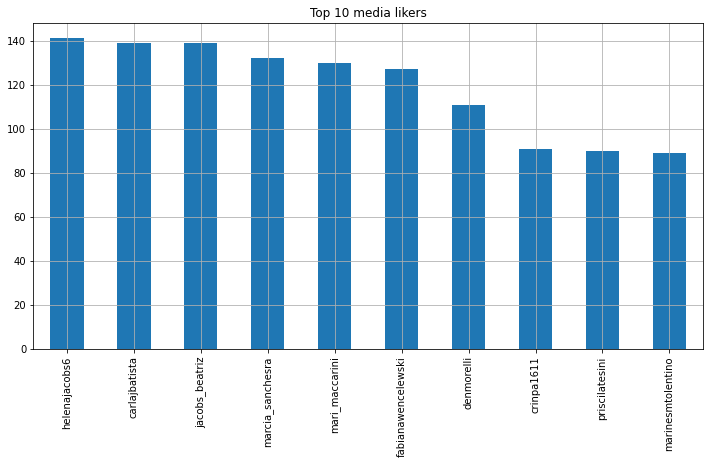

In [35]:
_ = df_likers.username.value_counts()[:10].plot(kind='bar', title='Top 10 media likers', grid=True, figsize=(12,6))

### Show pie plot with top 10 media likers

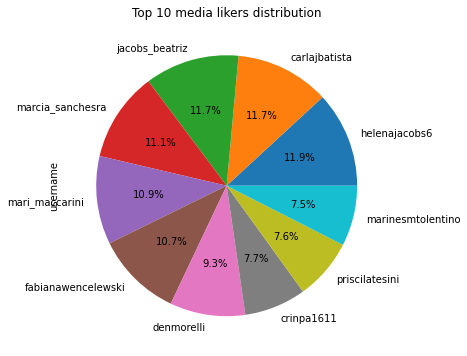

In [36]:
_ = df_likers.username.value_counts()[:10].plot(kind='pie', title='Top 10 media likers distribution', autopct='%1.1f%%', figsize=(12,6))

### Read top 10 commenters of my Instagram account

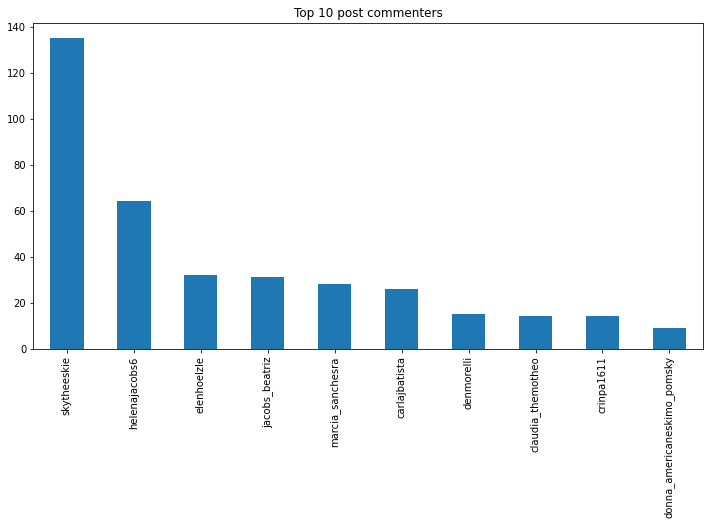

In [37]:
df_commenters['username'].value_counts()[:10].plot(kind='bar', figsize=(12,6), title='Top 10 post commenters')
# Converts date from unix time to YYYY-MM-DD hh24:mm:ss
df_commenters.created_at = pd.to_datetime(df_commenters.created_at, unit='s')
df_commenters.created_at_utc = pd.to_datetime(df_commenters.created_at_utc, unit='s')

### Plots a graph with number of comments per day of the week

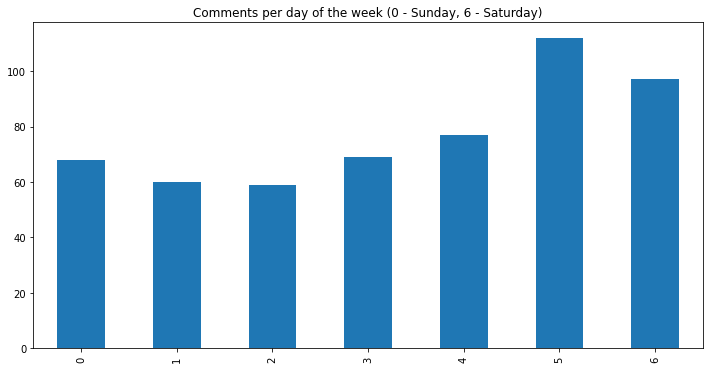

In [42]:
_ = df_commenters.created_at.dt.weekday.value_counts().sort_index().plot(kind='bar', figsize=(12,6), title='Comments per day of the week (0 - Sunday, 6 - Saturday)')

### Plots a graph with comments by the time of the day

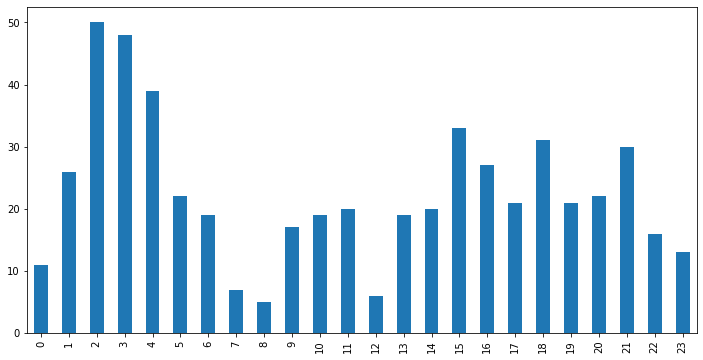

In [39]:
_ = df_commenters.created_at.dt.hour.value_counts().sort_index().plot(kind='bar', figsize=(12,6))

### Plots a graph with comments by the time of the day in Brazilian time

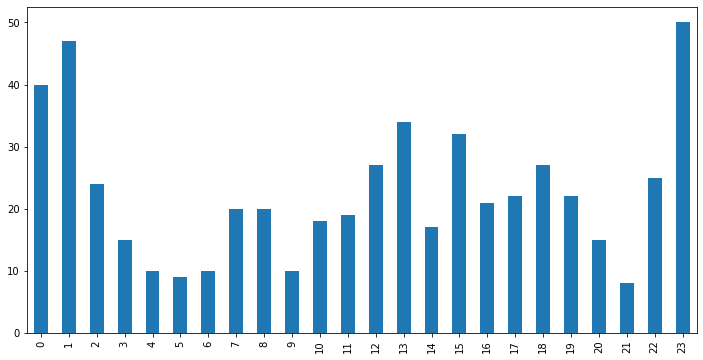

In [43]:
df_commenters['created_at_br'] = df_commenters.created_at_utc.dt.tz_localize('UTC').dt.tz_convert('America/Sao_Paulo')
_ = df_commenters.created_at_br.dt.hour.value_counts().sort_index().plot(kind='bar', figsize=(12,6))